In [2]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 5.2 MB/s 
     |████████████████████████████████| 182 kB 67.7 MB/s 
     |████████████████████████████████| 132 kB 74.0 MB/s 
     |████████████████████████████████| 212 kB 56.1 MB/s 
     |████████████████████████████████| 127 kB 67.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
from datasets import load_dataset
import PIL
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from IPython.display import display
from tqdm import tqdm
import pickle
import torchvision

In [16]:
dataset = load_dataset("cifar10")

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
train_df = dataset["train"]
test_df = dataset["test"]
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
class TrainDataset(Dataset):
  def __len__(self):
    return len(train_df)

  def __getitem__(self, index):
    img_x = train_df[index]["img"].resize((32, 32))
    return (to_tensor(img_x), torch.tensor([train_df[index]["label"]]))

class TestDataset(Dataset):
  def __len__(self):
    return len(test_df)

  def __getitem__(self, index):
    img_x = test_df[index]["img"].resize((32, 32))
    return (to_tensor(img_x), torch.tensor([test_df[index]["label"]]))

In [19]:
train_dataset = TrainDataset()
test_dataset = TestDataset()

In [20]:
train_set = DataLoader(
    train_dataset,
    batch_size = 200, 
    shuffle = True
)

test_set = DataLoader(
    test_dataset
)

In [24]:
df_test = pd.DataFrame(test_set)
df_train = pd.DataFrame(train_set)

In [ ]:
df_test.to_csv("test.csv", index = False)

In [25]:
def train(input, real):
  optim.zero_grad()

  output = model(input)
  lost = loss_function(output, real)
  
  lost.backward()
  optim.step()

  return lost

In [26]:
def encode_labels(batch_size, input):
  data = torch.zeros((batch_size, 10)).to(device)
  for i, j in enumerate(input):
    data[i][j.item()] = 1
  return data

In [27]:
df_train.columns = ["img", "label"]
df_test.columns = ["img", "label"]

In [35]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 64, 3, 1, 1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      
      nn.Dropout(p=0.3),

      nn.Conv2d(64, 128, 3, 1, 1),
      nn.BatchNorm2d(128),
      nn.ReLU(),

      nn.MaxPool2d(2, 2),

      nn.Conv2d(128, 256, 3, 1, 1),
      nn.BatchNorm2d(256),
      nn.ReLU(),

      nn.Dropout(p = 0.4),

      nn.Conv2d(256, 512, 3, 1, 1),
      nn.BatchNorm2d(512),
      nn.ReLU(),

      nn.MaxPool2d(2, 2),

      nn.Conv2d(512, 512, 3, 1, 1),
      nn.BatchNorm2d(512),
      nn.ReLU(),

      nn.Dropout(p = 0.4),

      nn.Conv2d(512, 512, 3, 1, 1),
      nn.BatchNorm2d(512),
      nn.ReLU(),

      nn.MaxPool2d(4, 4)
    )


    self.output = nn.Sequential(
      nn.Linear(2048, 512),
      nn.BatchNorm1d(512),
      nn.ReLU(),

      nn.Dropout(p = 0.3),

      nn.Linear(512, 10),
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), 2048)
    x = self.output(x)
    return x

In [40]:
model = Model().to(device)
loss_function = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr = 0.01)

In [41]:
def train(input, real):
  optim.zero_grad()

  output = model(input)
  lost = loss_function(output, real)
  
  lost.backward()
  optim.step()

  return lost


def encode_labels(batch_size, input):
  data = torch.zeros((batch_size, 10)).to(device)
  for i, j in enumerate(input):
    data[i][j.item()] = 1
  return data

In [42]:
history_loss = []
epochs = 300
for epoch in range(epochs):
  epoch_loss = 0
  for i in tqdm(range(len(df_train)), position=0, leave=True):
    input = df_train.iloc[i]["img"].to(device)
    real = encode_labels(200, df_train.iloc[i]["label"])
    epoch_loss = epoch_loss + train(input, real)
  print(f"Epoch:{epoch}. Loss:{epoch_loss.item()/i}")
  history_loss.append(epoch_loss.item()/i)

torch.save(model, "tecnicas_optim.plt")

 10%|█         | 26/250 [00:03<00:27,  8.07it/s]


KeyboardInterrupt: ignored

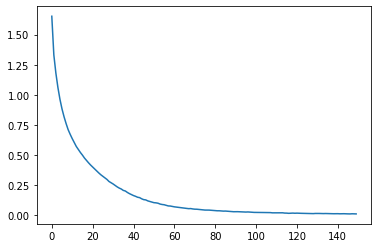

In [ ]:
plt.plot(history_loss)

In [29]:
#label: 0-9 with the following correspondence 0 airplane 1 automobile 2 bird 3 cat 4 deer 5 dog 6 frog 7 horse 8 ship 9 truck

In [30]:
model = torch.load("tecnicas_optim.plt")
labeled = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}
data = {i: [0, 0] for i in labeled.keys()}
model.eval()
with torch.no_grad():
  for i in range(len(df_test)):
    input = df_test.iloc[i]["img"].to(device)
    real = df_test.iloc[i]["label"]
    out = model(input)
    data[real.item()][1] += 1
    if torch.argmax(out[0]).item() == real.item():
      data[real.item()][0] += 1

print(data)

{0: [882, 1000], 1: [902, 1000], 2: [750, 1000], 3: [754, 1000], 4: [931, 1000], 5: [719, 1000], 6: [955, 1000], 7: [796, 1000], 8: [937, 1000], 9: [850, 1000]}


In [32]:
pip freeze > requirements.txt